In [184]:
import os
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

We calculate the satisfiability threshold for different values of $r$ (arXiv:2011.14270)

$$a_{sat} = \left( 2^{k-1} - \frac{1}{2} - \frac{1}{4\log 2}\right)\log 2 + o_k(1)$$


In [185]:
from math import log
def alpha_sat(k):
	return (2 ** (k - 1) - 0.5 - 1/(4 * log(2))) * log(2)

nae_sat_ratios = { k : round(alpha_sat(k), 2) for k in range(3,17)}
nae_sat_ratios

{3: 2.18,
 4: 4.95,
 5: 10.49,
 6: 21.58,
 7: 43.76,
 8: 88.13,
 9: 176.85,
 10: 354.29,
 11: 709.19,
 12: 1418.97,
 13: 2838.53,
 14: 5677.67,
 15: 11355.93,
 16: 22712.45}

Recall, $x$ satisfies a $k$-NAE-SAT instance iff $x$ satisfies the instance in the $k$-SAT formulation, and, for each clause, the literals within the clause are not all assigned the same truth value.

This means if $x$ satisfies a $k$-NAE-SAT instance then there is no clause where every literal has been set to true (and no clause where every literal has been set to false since the clause wouldn't be satisfied)...

I.e. $x$ satisfies a k-NAE-SAT instance iff $x$ and $\neg x$ satisfy the same instance in the k-SAT formulation.

As such, we create a new `nae_cnf.py` to encode this and use the same pytorch solver as before.


In [186]:
# Combined results
all_ps = [1, 2, 4, 8, 16, 18, 20, 22, 24, 30]
ks = [i for i in range(3, 11)]
ns = [i for i in range(12, 21)]
psuccs = {k : {n : {p : 0 for p in all_ps} for n in ns} for k in ks}
psucc_coeffs = {k : {p : [] for p in all_ps} for k in ks}

We test for $p = 1, 2, 4, 8$ before scaling up

In [187]:
ps = all_ps[:3]
num_proc = 10
batch_size = 250

In [188]:
# Load and combine JSON files
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp3/results"
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/p_succ_{n}_{k}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

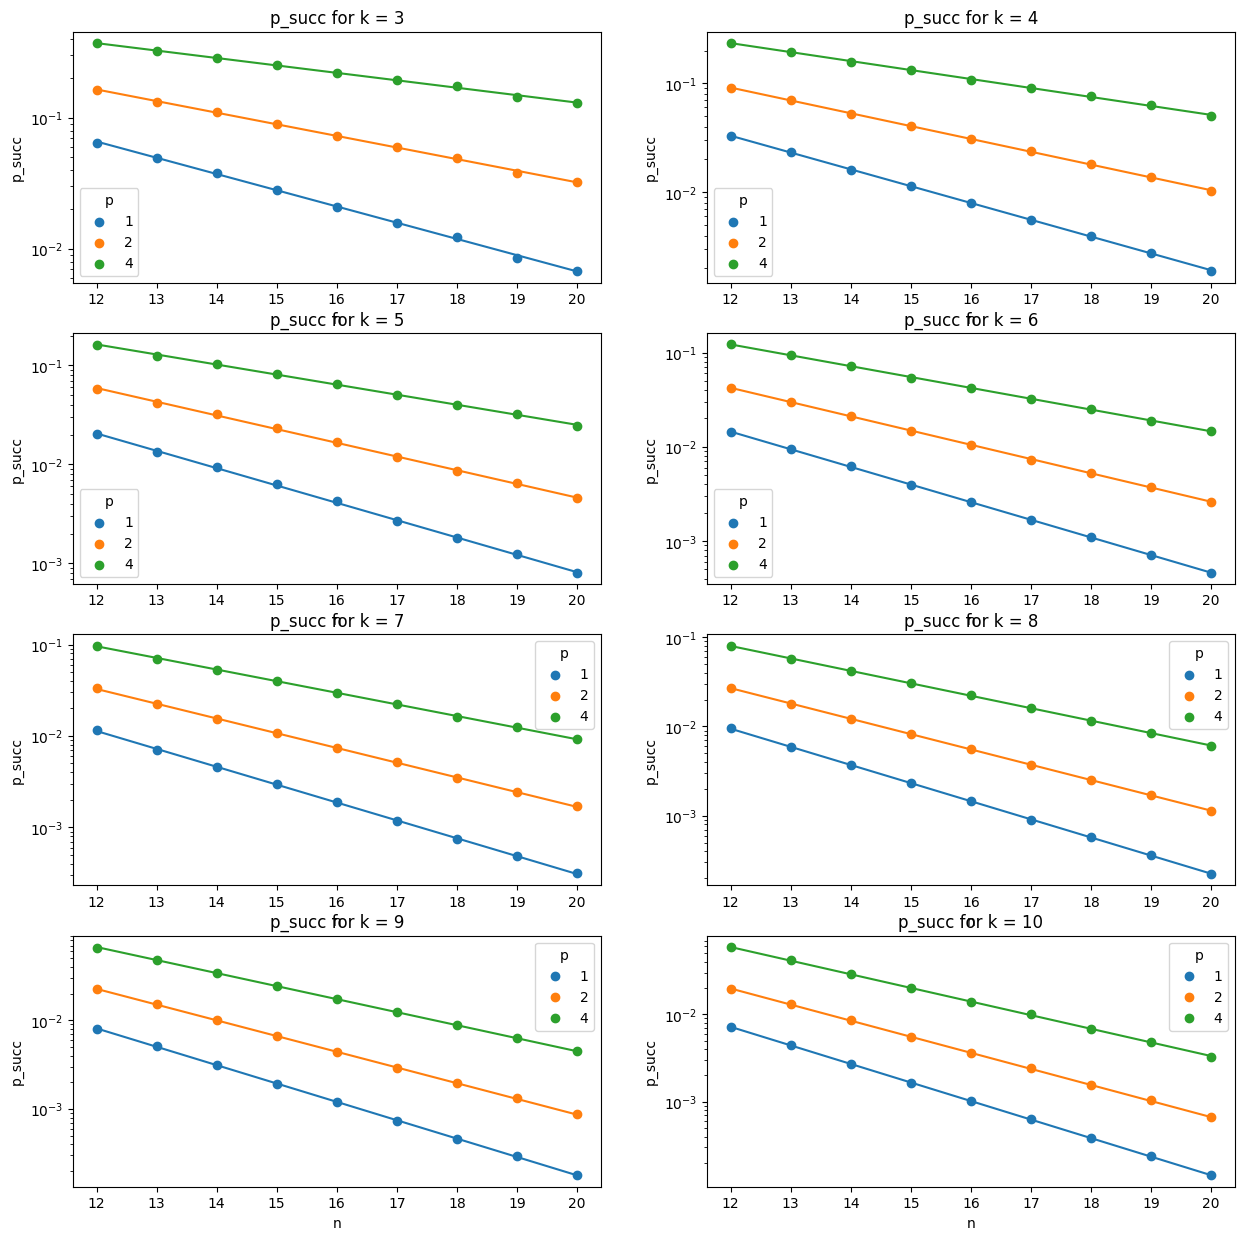

In [189]:
# Plot p succ
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(15, 15))
for (ax, k) in zip(axs.flatten(), ks):
	psucc = psuccs[k]

	x = ns
	ys = [[psucc[n][p] for n in x] for p in ps]

	for (p, y) in zip(ps, ys):
		# Points
		ax.scatter(x, y, label=p)

		# Line of best fit
		coefficients, error = np.polyfit(x, np.log(y), 1, cov=True)
		psucc_coeffs[k][p] = coefficients.tolist()
		polynomial = np.poly1d(coefficients)
		ax.plot(x, np.exp(polynomial(x)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('p_succ')
	ax.legend(title='p')
	ax.set_title(f'p_succ for k = {k}')


We extend to $p = 8, 16, 24, 30$

In [190]:
ps = [8, 16, 24, 30]
# n = 20 too large
ns = ns[:-1]

parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp3/results2"
# Load and combine JSON files
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/p_succ_{n}_{k}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				if p == 30:
					filename = f'{dir}/p_succ_{n}_{k}_{30}_{index}.json' 
					with open(filename, 'r') as f:
						data = json.load(f)
						psuccs[k][n][30] += data[str(n)][str(30)] / (batch_size * num_proc)
				else:
					psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

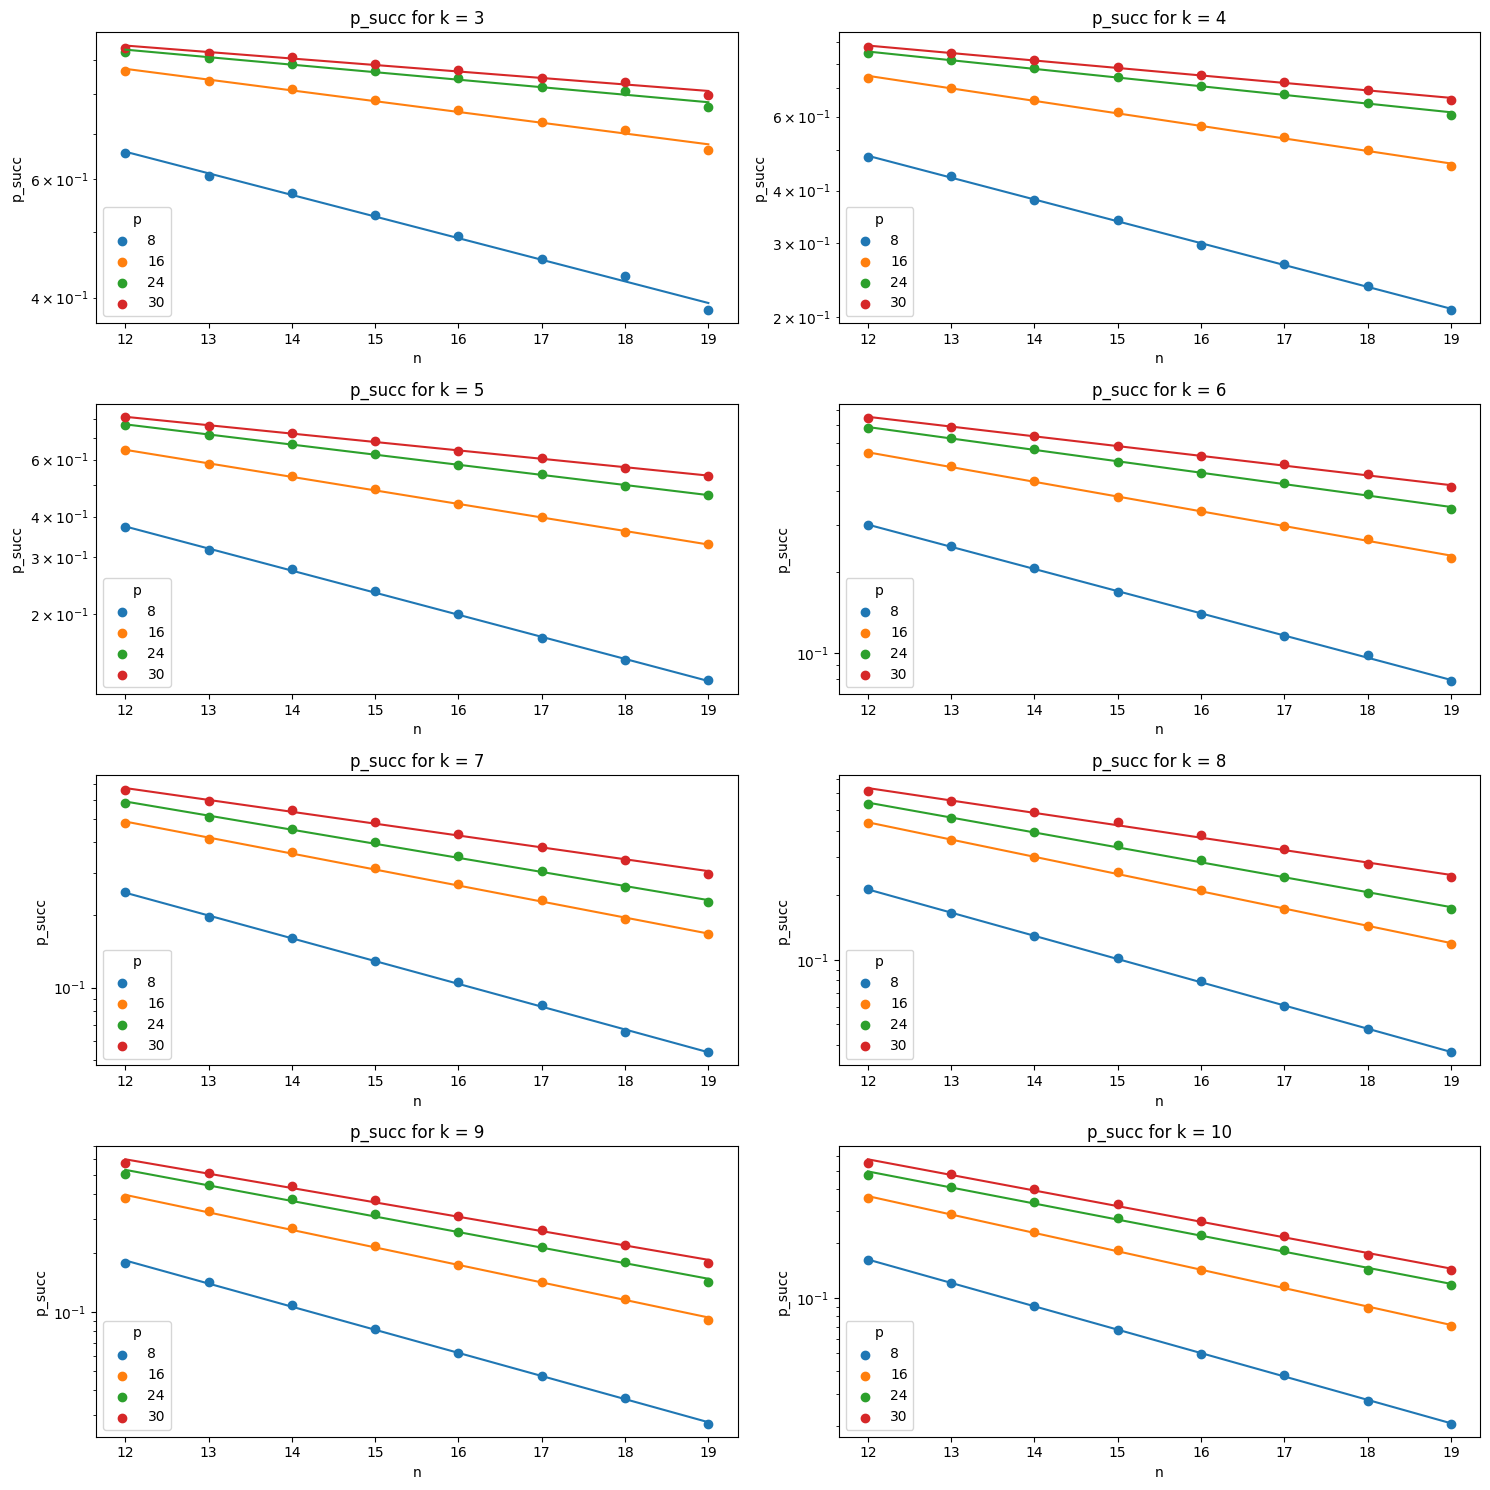

In [191]:
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(15, 15))
for (ax, k) in zip(axs.flatten(), ks):
	psucc = psuccs[k]

	x = ns
	ys = [[psucc[n][p] for n in x] for p in ps]

	for (p, y) in zip(ps, ys):
		# Points
		ax.scatter(x, y, label=p)

		# Line of best fit
		coefficients = np.polyfit(x, np.log(y), 1)
		psucc_coeffs[k][p] = list(coefficients)
		polynomial = np.poly1d(coefficients)
		ax.plot(x, np.exp(polynomial(x)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('p_succ')
	ax.legend(title='p')
	ax.set_title(f'p_succ for k = {k}')

fig.tight_layout()
plt.show()

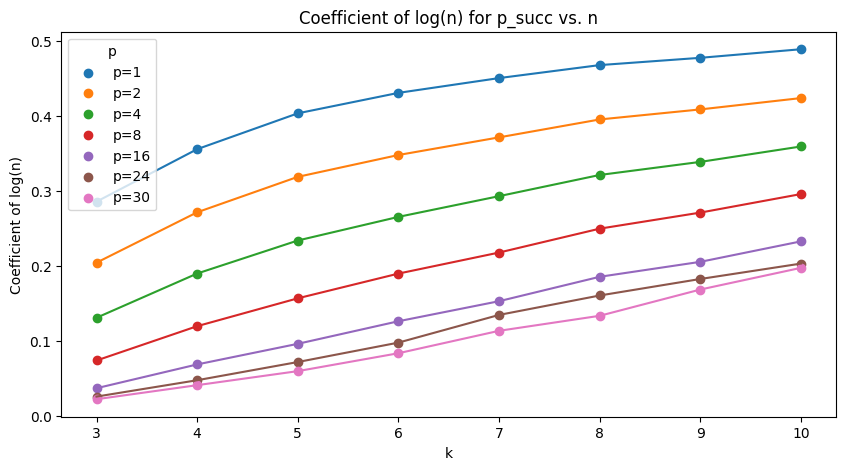

In [192]:
# Plot coefficients as a function of p
fig, ax = plt.subplots(figsize=(10, 5))
for p in [1, 2, 4, 8, 16, 24, 30]:
    coefficients = [-psucc_coeffs[k][p][0] for k in ks]
    ax.scatter(ks, coefficients, label=f"p={p}")
    ax.plot(ks, coefficients)
ax.set_xlabel("k")
ax.set_ylabel("Coefficient of log(n)")
ax.legend(title="p")
ax.set_title("Coefficient of log(n) for p_succ vs. n")
plt.show()
fig.tight_layout()
plt.show()

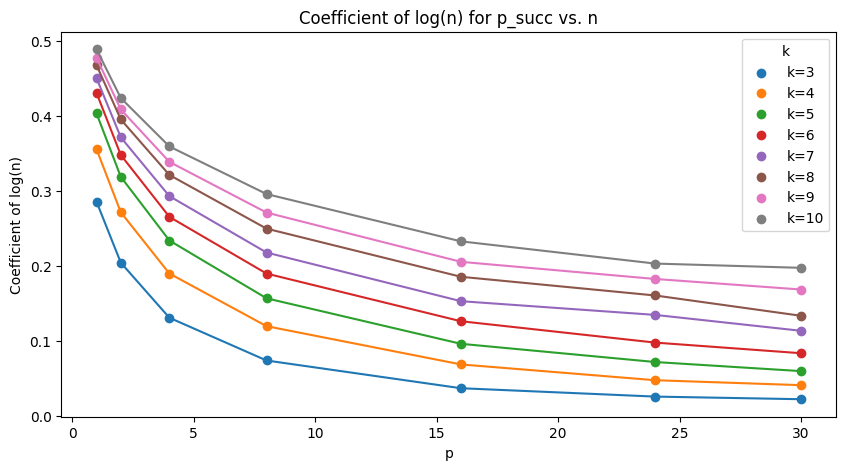

In [193]:
# Plot coefficients as a function of k
fig, ax = plt.subplots(figsize=(10, 5))
for k in ks:
    coefficients = [-psucc_coeffs[k][p][0] for p in [1, 2, 4, 8, 16, 24, 30]]
    ax.scatter([1, 2, 4, 8, 16, 24, 30], coefficients, label=f"k={k}")
    ax.plot([1, 2, 4, 8, 16, 24, 30], coefficients)
ax.set_xlabel("p")
ax.set_ylabel("Coefficient of log(n)")
ax.legend(title="k")
ax.set_title("Coefficient of log(n) for p_succ vs. n")
plt.show()

Mrt vs. psucc

In [195]:
import torch
import h5py
# Load, combine and calculate median running time from hdf5 files
mrts = {k : {n : {} for n in ns} for k in ks}

# p = 1, 2, 4
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp3/results"
for k in ks:
	for n in ns:
		for p in [1, 2, 4]:
			# Initialise empty tensor for runtimes
			rt = torch.zeros(size=(num_proc * batch_size, ))
			for proc in range(num_proc):
				index = proc * batch_size
				filename = f'{dir}/rt_{n}_{k}_{p}_{index}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					rt[index : index + batch_size] = fresh
			mrts[k][n][p] = torch.median(rt)

# p = 8, 16, 24, 30
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp3/results2"

for k in ks:
	for n in ns:
		for p in [8, 16, 24, 30]:
			# Initialise empty tensor for runtimes
			rt = torch.zeros(size=(num_proc * batch_size, ))
			for proc in range(num_proc):
				index = proc * batch_size
				filename = f'{dir}/rt_{n}_{k}_{p}_{index}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					rt[index : index + batch_size] = fresh
			mrts[k][n][p] = torch.median(rt)

Plot scaling predicted by success probability vs median running time:

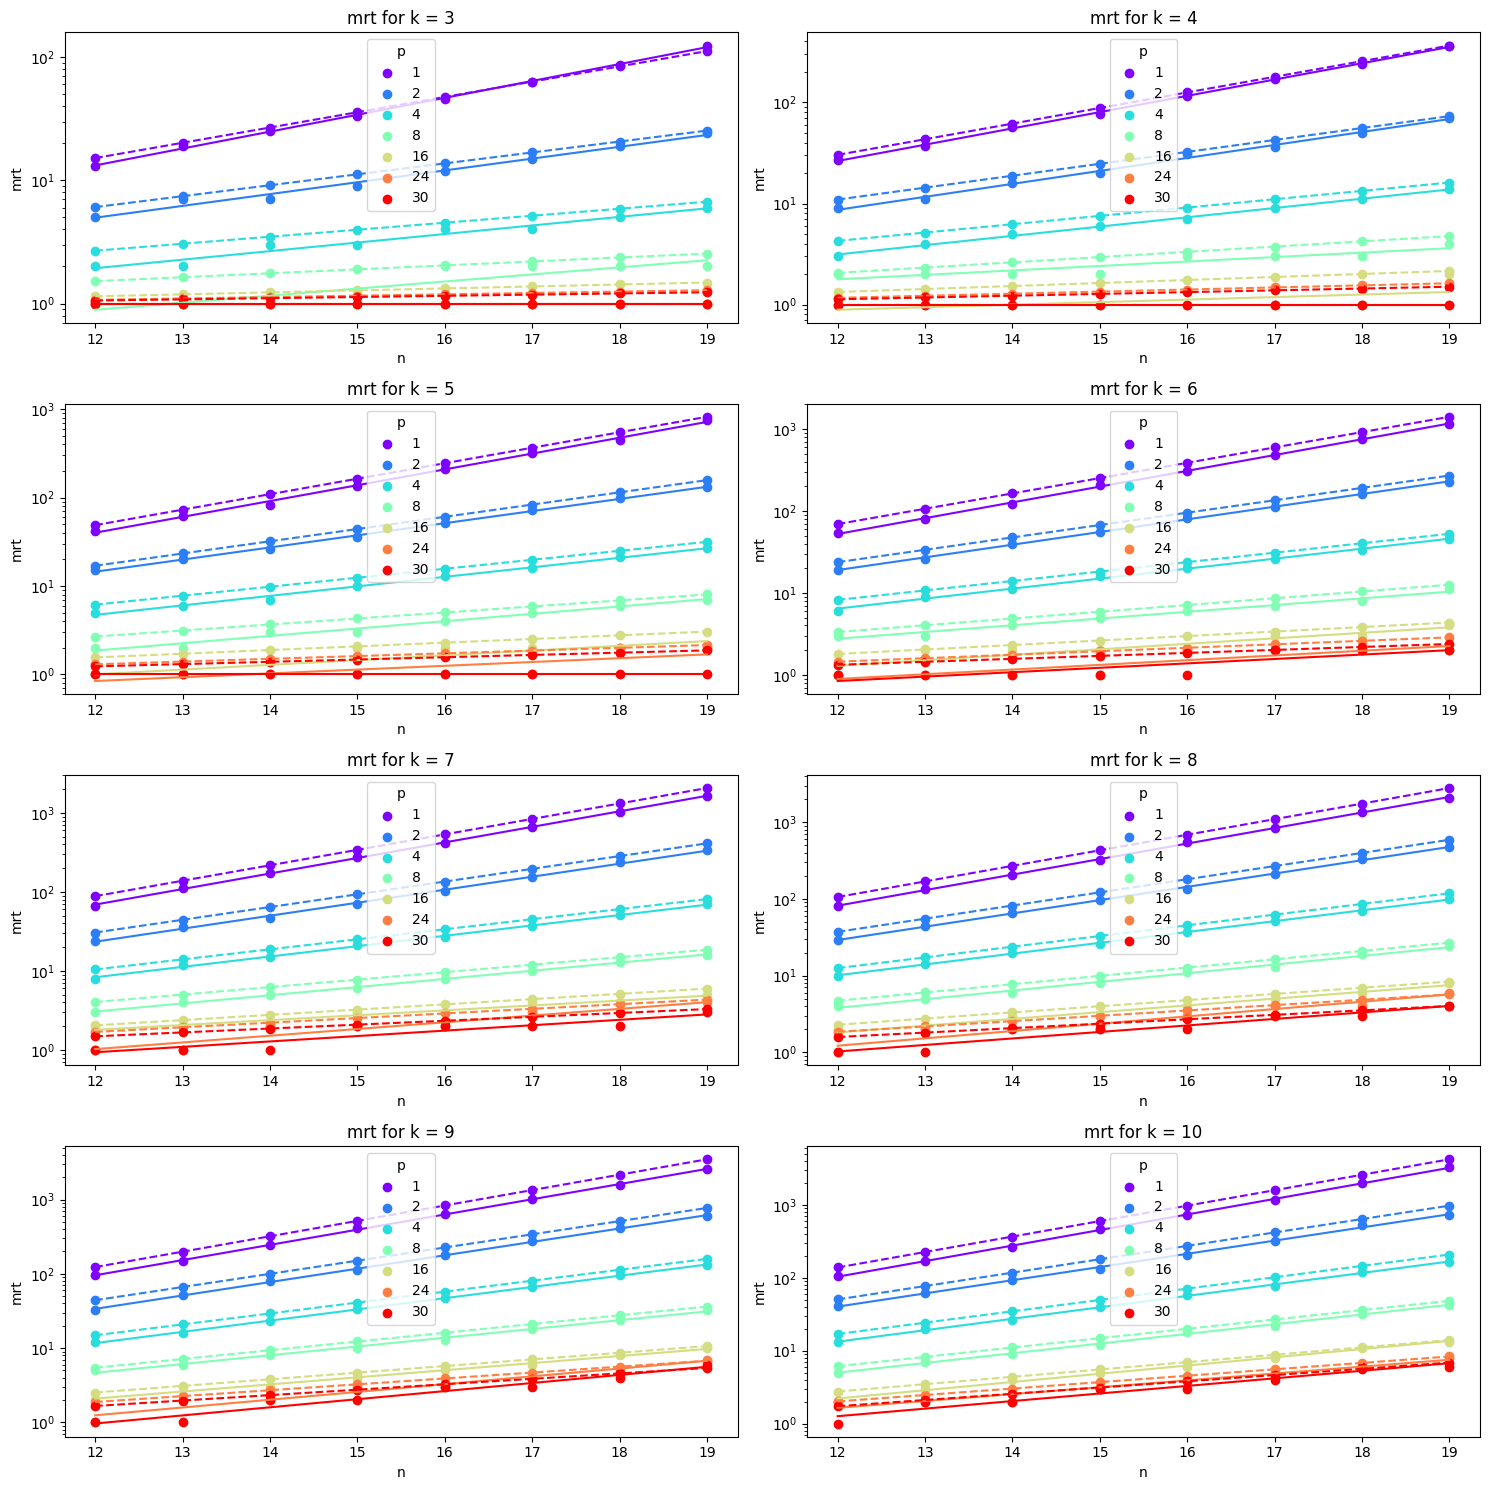

In [197]:
ps = [1, 2, 4, 8, 16, 24, 30]
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(15, 15))
qaoa_coeffs = {k : {p : {} for p in ps} for k in ks}
for (ax, k) in zip(axs.flatten(), ks):
	mrt = mrts[k]

	x = list(mrt.keys())
	ys = [[mrt[n][p] for n in x] for p in ps]
	color = iter(plt.cm.rainbow(np.linspace(0, 1, len(ps))))

	for (p, y) in zip(ps, ys):
		c = next(color)
		# Points
		ax.scatter(x, y, label=p, color=c)

		# Line of best fit
		fit = np.polyfit(x, np.log(y), 1, full=True)
		qaoa_coeffs[k][p]['c'] = list(fit[0])
		qaoa_coeffs[k][p]['r'] = list(fit[1])
		polynomial = np.poly1d(fit[0])
		#print(polynomial)
		ax.plot(x, np.exp(polynomial(x)), color=c)

		# Psucc lines
		psucc_polynomial = np.poly1d(np.negative(psucc_coeffs[k][p]))
		#print(psucc_polynomial)
		ax.scatter(x, np.exp(psucc_polynomial(x)), color=c)
		ax.plot(x, np.exp(psucc_polynomial(x)), linestyle='dashed', color=c)

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('mrt')
	ax.legend(title='p')
	ax.set_title(f'mrt for k = {k}')

fig.tight_layout()
plt.show()

In [198]:
with open(f'{dir}/coeffs.json', 'w') as f:
    json.dump(qaoa_coeffs, f)

In [199]:
qaoa_coeffs

{3: {1: {'c': [0.31547120355424435, -1.2044614922432668],
   'r': [0.005018713740534728]},
  2: {'c': [0.22079829942612428, -1.045632052989233],
   'r': [0.030479974895227826]},
  4: {'c': [0.1597912879217239, -1.25710181962876],
   'r': [0.04609853717281689]},
  8: {'c': [0.13202803475516184, -1.6998609474727082],
   'r': [0.22878715074219674]},
  16: {'c': [0.0, 0.0], 'r': [0.0]},
  24: {'c': [0.0, 0.0], 'r': [0.0]},
  30: {'c': [0.0, 0.0], 'r': [0.0]}},
 4: {1: {'c': [0.37072254930223736, -1.1775920050484774],
   'r': [0.0057213201564132185]},
  2: {'c': [0.29524497191111243, -1.383613904317217],
   'r': [0.019940449885685958]},
  4: {'c': [0.2114122765404838, -1.3936163272176465],
   'r': [0.007379440772560884]},
  8: {'c': [0.10120495728084022, -0.6368368353162492],
   'r': [0.0876822011395089]},
  16: {'c': [0.057762265205383294, -0.8086717128753658],
   'r': [0.28026425965919105]},
  24: {'c': [0.0, 0.0], 'r': [0.0]},
  30: {'c': [0.0, 0.0], 'r': [0.0]}},
 5: {1: {'c': [0.412161